In [7]:
import sys
sys.path.append('lib/src/')
import torch
from torch import nn
import os
import numpy as np
from matplotlib import pyplot as plt

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler
from lib.src.pythae.trainers.training_callbacks import WandbCallback

from geometric_perspective_on_vaes.sampling import build_metrics, hmc_sampling

%reload_ext autoreload
%autoreload 2

In [8]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'))[:-1000, :-1, :, :, :].to(device) #removing the last obs which is the same as the first
eval_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'), map_location="cpu")[-1000:, :-1, :, :, :].to(device)
#test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, -1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3).reshape(-1, 3, 64, 64)
eval_data = eval_data.permute(0, 1, 4, 2, 3).reshape(-1, 3, 64, 64)
#test_data = test_data.permute(0, 3, 1, 2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([56000, 3, 64, 64])


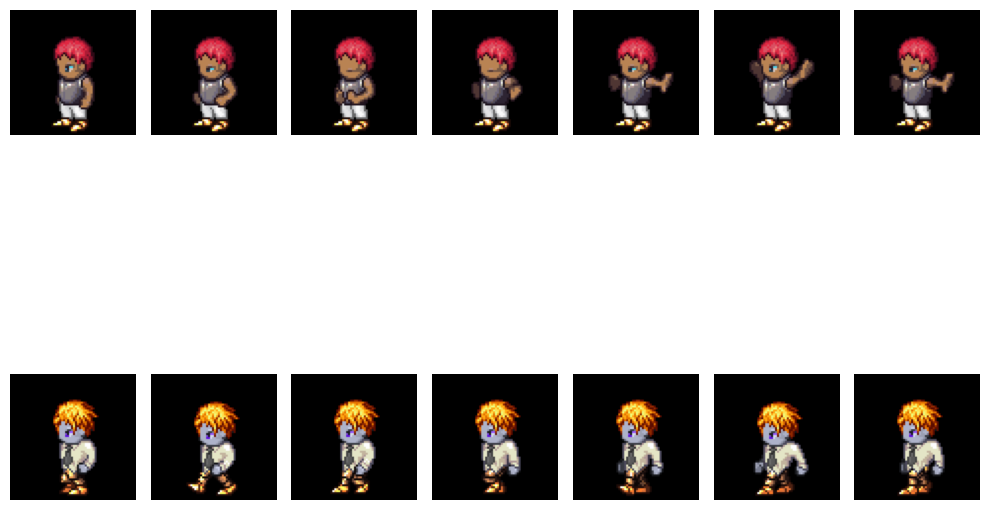

In [19]:
#check

plt.figure(figsize=(10, 10))
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(train_dataset[i][0].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
input_dim = (3, 64, 64)
f = 32 #subsampling factor
new_num_channels = 3
latent_dim = new_num_channels* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='pre-trained_vae',
num_epochs=100,
learning_rate=1e-3,
per_device_train_batch_size=200,
per_device_eval_batch_size=200,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=50,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 3, "factor": 0.8})


Latent dim: 12


In [13]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
encoder = Encoder_Chairs(model_config)
decoder = Decoder_Chairs(model_config)
device = 'cpu'
print(device)

vae = VAE(model_config=model_config, encoder=encoder, decoder=decoder).to(device)
vae.load_state_dict(torch.load('pre-trained_vae/VAE_training_2024-06-16_15-12-03/final_model/model.pt')["model_state_dict"])


x = train_dataset[0:100]
print(x.data.shape)
x.data = x.data.unsqueeze(0).to(device)
print(x.data.shape)

out = vae(x)
out['recon_x'].shape

cpu
torch.Size([100, 3, 64, 64])
torch.Size([1, 100, 3, 64, 64])


torch.Size([1, 100, 3, 64, 64])

In [5]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name="pre_training_VAE_latdim8_fulldataset", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: meilame-tayebjee. Use `wandb login --relogin` to force relogin


In [ ]:
vae = vae.to('cuda')
pipeline = TrainingPipeline(
    training_config=training_config,
    model=vae
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset,
    callbacks=callbacks
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15753657..1.0925655].


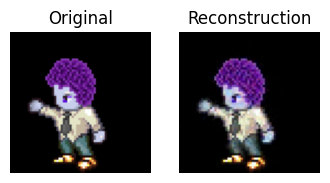

In [14]:
idx = 10000
x = train_dataset[idx]
vae = vae.to('cpu')
out = vae(x)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.data.cpu().permute(1, 2, 0))
plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out['recon_x'].data.cpu().permute(1, 2, 0))
plt.title('Reconstruction')
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10077848..1.2407919].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14756277..1.1115332].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13321574..1.2194867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15336202..1.0542982].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20283978..1.1021127].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15426448..1.081871].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2

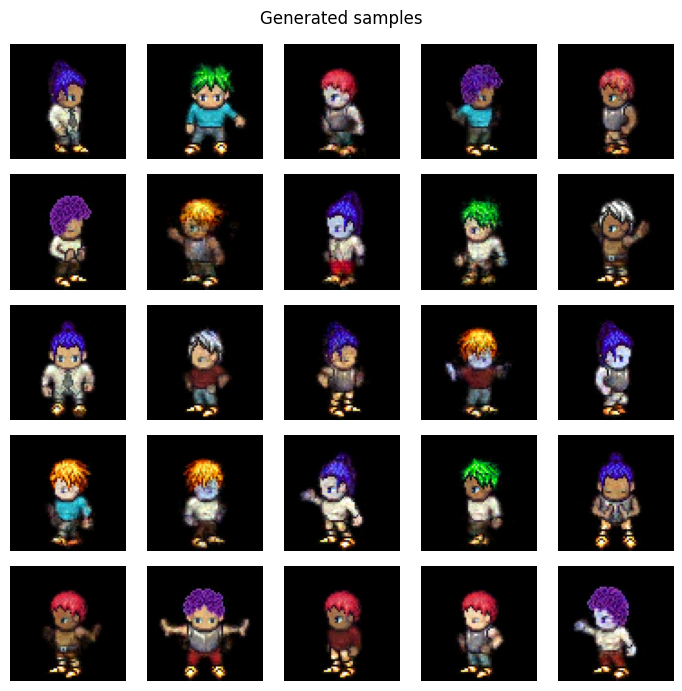

In [15]:
normal_sampler = NormalSampler(
    model=vae
)
gen_data = normal_sampler.sample(
    num_samples=25
)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(7, 7))
plt.suptitle('Generated samples')
for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5+j].cpu().permute(1, 2, 0))
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)
device = 'cuda'
vae = vae.to(device)

mu = []
log_var = []
with torch.no_grad():
    for _ , x in enumerate(train_loader):

        data = x.data

        out = vae.encoder(data.to(device))

        mu_data, log_var_data = out.embedding, out.log_covariance

        mu.append(mu_data)
        log_var.append(log_var_data)

mu = torch.cat(mu)
log_var = torch.cat(log_var)

In [17]:
print('Running Kmedoids')
print(device)
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=500).fit(mu.detach().cpu())
print('done')
medoids = torch.tensor(kmedoids.cluster_centers_).to(device)
centroids_idx = kmedoids.medoid_indices_ #

Running Kmedoids
cuda


/users/eleves-a/2020/meilame.tayebjee/miniconda3/envs/geomstats-pytorch/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 112 is empty! self.labels_[self.medoid_indices_[112]] may not be labeled with its corresponding cluster (112).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/envs/geomstats-pytorch/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 113 is empty! self.labels_[self.medoid_indices_[113]] may not be labeled with its corresponding cluster (113).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/envs/geomstats-pytorch/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 124 is empty! self.labels_[self.medoid_indices_[124]] may not be labeled with its corresponding cluster (124).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/envs/geomstats-pytorch/lib/python3.10/site-packages/sklearn_extra/cluster/_k_m

done


In [18]:
print("Finding temperature")
eps_lf = 0.1
lbd = 0.01
T = 0
T_is = []
for i in range(len(medoids)-1):
    mask = torch.tensor([k for k in range(len(medoids)) if k != i])
    dist = torch.norm(medoids[i].unsqueeze(0) - medoids[mask], dim=-1)
    T_i =torch.min(dist, dim=0)[0]
    T_is.append(T_i.item())

T = np.max(T_is)
print('Best temperature found: ', T)

print('Building metric')
vae = build_metrics(vae, mu, log_var, centroids_idx, T=T*1.5, lbd=lbd)

Finding temperature
Best temperature found:  2.27055313060455
Building metric


In [19]:
n_samples = 1000
batch_size = 1000

all_z = []

device = 'cuda'
vae = vae.to(device)
mu = mu.to(device)

for j in range(0, int(n_samples / batch_size)):
    z, p = hmc_sampling(vae, mu, n_samples=batch_size, mcmc_steps_nbr=100)
    all_z.append(z)

p = p[0]
all_z = torch.cat(all_z, dim=0)
all_z.shape

omega
tensor([[[[1.4555e-29]],

         [[1.3514e-18]],

         [[2.3396e-37]],

         ...,

         [[7.6645e-22]],

         [[4.8964e-09]],

         [[1.5788e-10]]],


        [[[3.2121e-20]],

         [[9.2585e-23]],

         [[1.6096e-08]],

         ...,

         [[7.9851e-11]],

         [[1.0020e-18]],

         [[2.3960e-21]]],


        [[[1.1840e-20]],

         [[5.7759e-13]],

         [[1.2160e-19]],

         ...,

         [[3.8448e-10]],

         [[1.4897e-11]],

         [[1.3921e-12]]],


        ...,


        [[[9.3366e-31]],

         [[1.9772e-20]],

         [[8.7627e-39]],

         ...,

         [[8.4941e-26]],

         [[7.3358e-07]],

         [[5.9318e-09]]],


        [[[1.4487e-18]],

         [[9.7699e-18]],

         [[4.3963e-15]],

         ...,

         [[5.0653e-08]],

         [[1.7972e-15]],

         [[1.8433e-19]]],


        [[[2.5385e-08]],

         [[6.6215e-11]],

         [[7.9974e-11]],

         ...,

         [[2.5715e-11

[True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False

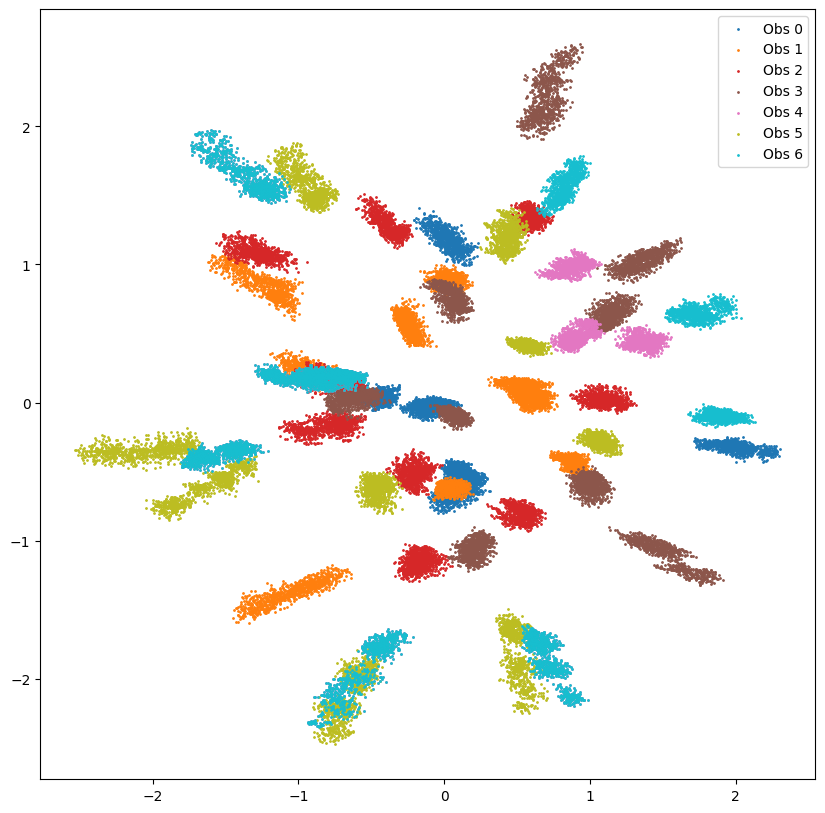

In [48]:
from sklearn.decomposition import PCA

#########
NUM_OBS = 7
DISPLAYED_OBS =  range(NUM_OBS)
PROJECTING_OBS = [6] #range(NUM_OBS)
#########

train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)





train_pca = pca.transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.cpu().detach().numpy())
p_pca  = pca.transform(p.cpu().detach().numpy())
colors = plt.get_cmap('tab10', NUM_OBS)




plt.figure(figsize=(10, 10))
for i in DISPLAYED_OBS:
    indices = [k % NUM_OBS == i for k in range(train_embeddings.shape[0])]
    plt.scatter(train_pca[indices, 0], train_pca[indices, 1], label=f'Obs {i}', s= 1, color = colors(i))


#plt.scatter(train_pca[:, 0], train_pca[:, 1], label='Train data', s= 1)

#plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], s = 10, label='Generated data', c = 'black')

plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16903879..1.1797792].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1388331..1.0972666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10988259..1.1434411].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.057224073..1.0662435].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0936023..1.12536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08590373..1.0908431].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.138

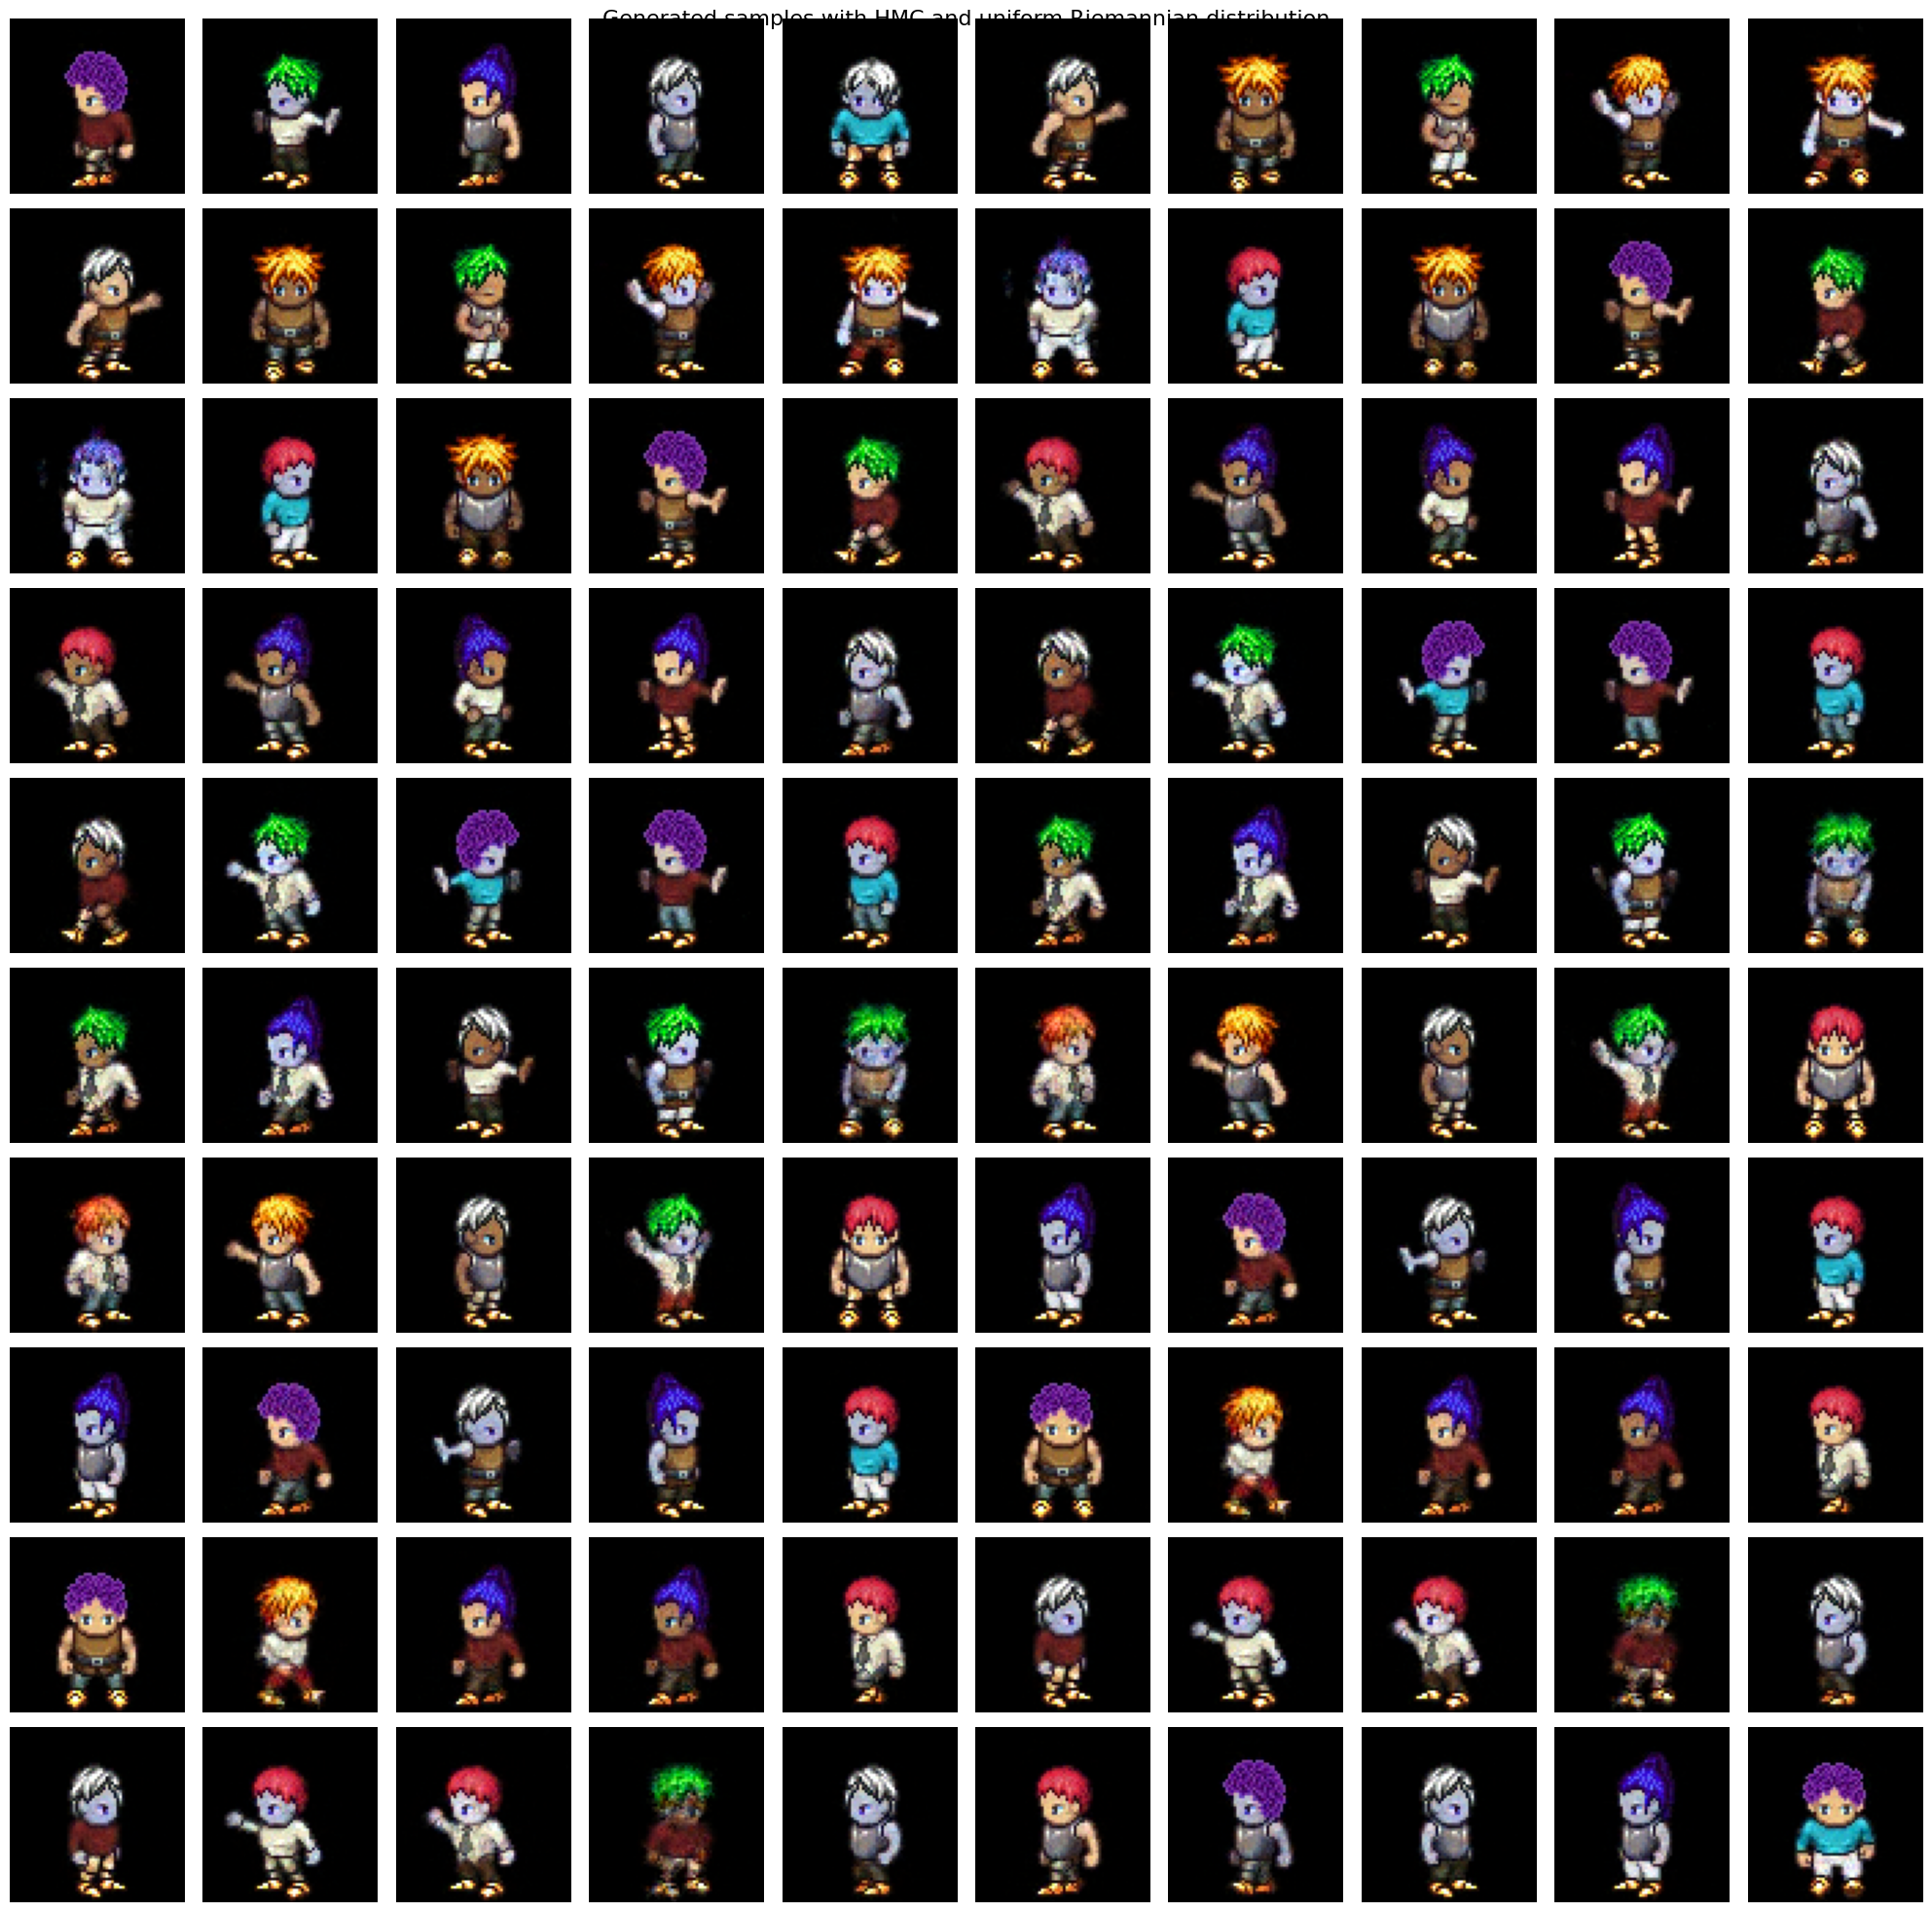

In [23]:
vae = vae.to('cpu')
all_z= all_z.to('cpu').detach()

gen_data = vae.decoder(all_z).reconstruction.detach()

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axes[i][j].imshow(gen_data[i*5+j].permute(1, 2, 0))
        axes[i][j].axis('off')

fig.suptitle('Generated samples with HMC and uniform Riemannian distribution', fontsize=16)
plt.tight_layout()
plt.show()

In [30]:
import geomstats.backend as gs